# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from datetime import datetime
import joblib

# Импорт данных

In [3]:
taxi = pd.read_csv('../data/taxi.csv')

# 3.1 Выявление ключевых характеристик

В модуле B был проведен сравнительный анализ и были сопоставлены выявленные кластеры в наборах данных по
годам.<br>
Для каждого кластера выявили не менее двух характеристик, проявляющих устойчивые закономерности на протяжении трёх лет и описали эти закономерности.<br>
Атрибуты: ```total_amount, trip_distance```

# 3.2 Визуализация закономерностей

Определим динамику изменения выявленных характеристик и покажем её на графиках.

Проведем анализ методов визуалзации данных:
- matplotlib - популярная Python-библиотека для визуализации данных. Она используется для создания любых видов графиков: линейных, круговых диаграмм, построчных гистограмм и других — в зависимости от задач.<br>
Является низкоуровневой библиотекой, что позволяет ей работать быстро и гибко.
- seaborn - это библиотека для создания статистических графиков на Python. Она основывается на matplotlib и тесно взаимодействует со структурами данных pandas.
Архитектура Seaborn позволяет вам быстро изучить и понять свои данные. Seaborn захватывает целые фреймы данных или массивы, в которых содержатся все ваши данные, и выполняет все внутренние функции, нужные для семантического маппинга и статистической агрегации для преобразования данных в информативные графики.
- plotly -  библиотека для визуализации данных, состоящая из нескольких частей:
Front-End на JS
Back-End на Python (за основу взята библиотека Seaborn)
Back-End на R

Для нашего анализа я выберу matplotlib, так как у нас много данных и нам вожна скорость отрисовки графиков.

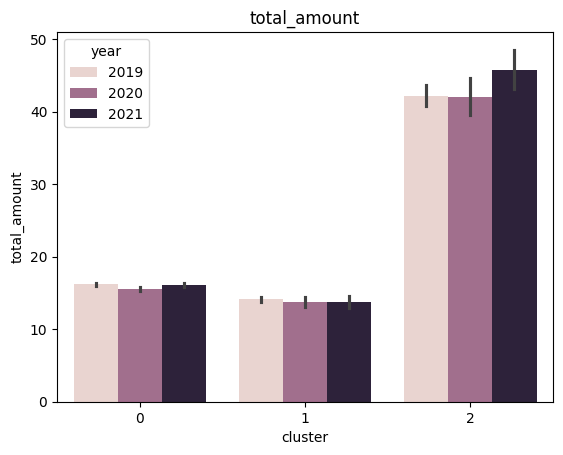

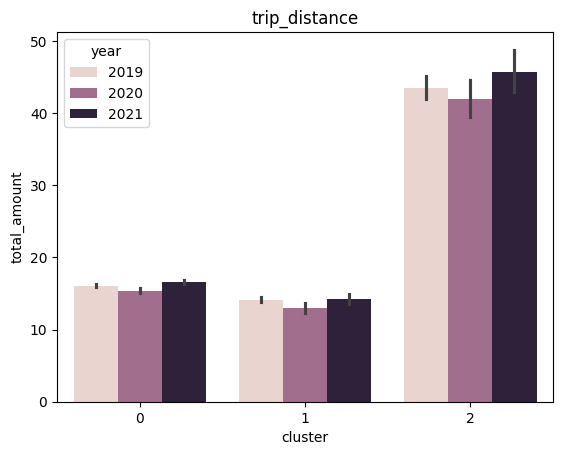

In [36]:
for col in ['total_amount', 'trip_distance']:
    data = taxi[taxi['year'].isin([2019, 2020, 2021])].sample(10000)
    sns.barplot(data=data, x='cluster', y='total_amount', hue='year')
    plt.title(col)
    plt.show()

#### На графике наглядно изображено, что для каждого кластера характеристики уменьшаются к 2020 году, а к 2021 обратно возрастают

# 3.3 Прогнозирование динамики изменения характеристик

Прогноз будет выполнен по всем 3 наборам данных, их мы объединили в один набор в модуле B.

In [4]:
taxi.head()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge,day,month,year,cluster
0,1.0,0.0,13.56,7.0,1.68,0.3,16,8,2019,0
1,2.0,0.0,19.80,16.5,3.56,0.3,4,11,2019,1
2,2.0,0.0,8.30,7.0,1.40,0.3,1,1,2019,1
3,2.0,0.0,13.30,9.5,1.64,0.3,7,7,2019,1
4,1.0,0.0,14.30,8.5,1.90,0.3,3,5,2019,0


Рассмотрим 3 алгоритма регрессиии: ```LinearRegression, DecisionTree, RandomForest```

<b>LinearRegression</b>:
- Простота (модель легко построить, она быстро обучается)
- Интерпретируемость
- Хорошо работает только с теми данными, где зависимость между признаками и целевой переменной линейна. В случае нелинейной зависимости модель бесполезна

<b>DecisionTree</b>:
- Интерпретируемость
- Способность обрабатывать несбалансированные данные
- Частое переобучение
- Чувствительность к небольшим изменениям

<b>RandomForest</b>:
- Способность эффективно обрабатывать данные с большим числом признаков и классов
- Нечувствительность к масштабированию
- Они сложнее стандартных деревьев решений (DecisionTree)
- Интенсивный в вычислительном плане, требующий больше памяти и вычислительной мощности


Для нашей задачи важна скорость работы и простота использования, поэтому берем <b>LinearRegression</b>.

### Обучение модели

Будем предсказывать две характеристики ```total_amount, trip_distance``` во времени

In [8]:
total_amount = taxi['total_amount']
trip_distance = taxi['trip_distance']

X = taxi[['day', 'month', 'year', 'cluster']]
X.head()

,day,month,year,cluster
0,16,8,2019,0
1,4,11,2019,1
2,1,1,2019,1
3,7,7,2019,1
4,3,5,2019,0


#### total_amount

In [54]:
model_total_amount = LinearRegression()
model_total_amount.fit(X, total_amount)

LinearRegression()

#### Делаем прогноз в разрезе каждого кластера

In [107]:
preds = []
for cluster in range(3):
    # Прогнозирование на 2 года вперед
    for year in [2022, 2023]:
        for month in range(1, 13):
            day_range = range(1, 29) if month == 2 else range(1, 30)
            for day in day_range:
                total_amount_pred = model_total_amount.predict(pd.DataFrame([[day, month, year, cluster]], columns=X.columns))
                preds.append(np.array([day, month, year, cluster, total_amount_pred[0]]))

total_amount_preds = pd.DataFrame(preds, columns=list(X.columns) + ['total_amount_pred'])
total_amount_preds.head()

,day,month,year,cluster,total_amount_pred
0,1.0,1.0,2022.0,0.0,15.208268
1,2.0,1.0,2022.0,0.0,15.204317
2,3.0,1.0,2022.0,0.0,15.200366
3,4.0,1.0,2022.0,0.0,15.196415
4,5.0,1.0,2022.0,0.0,15.192465


#### Визуализация

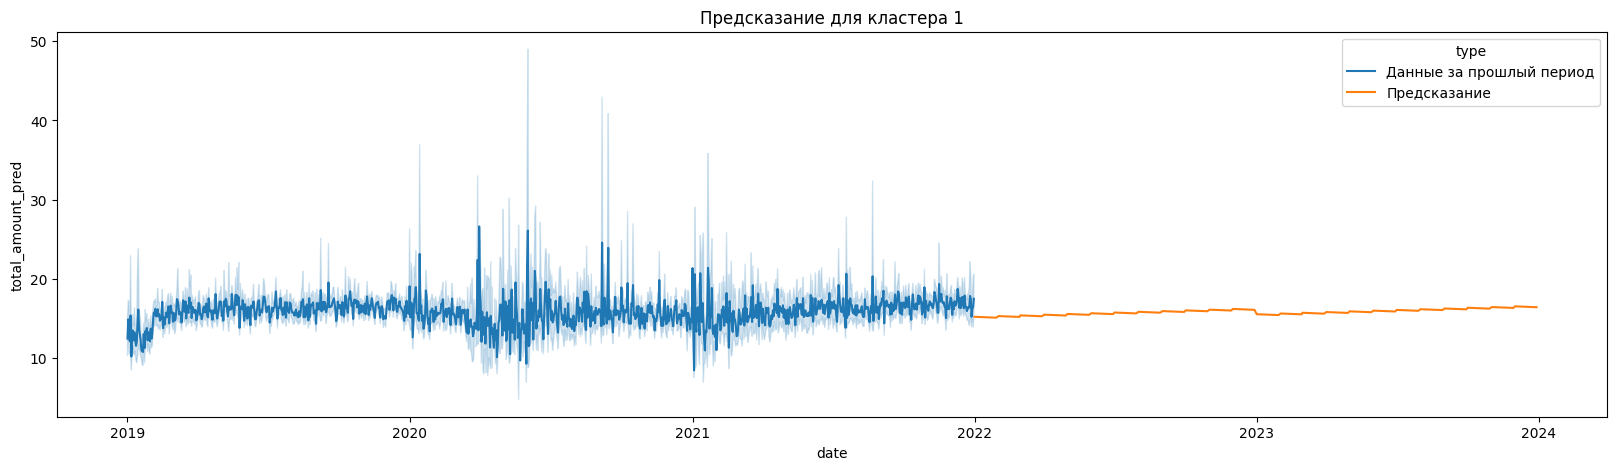

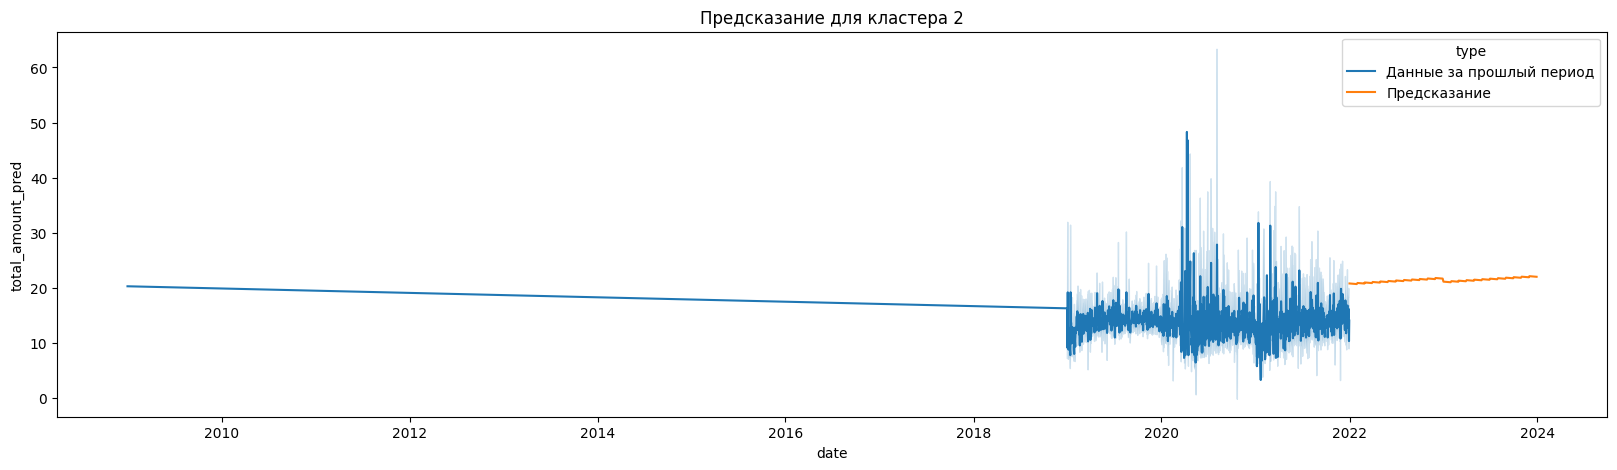

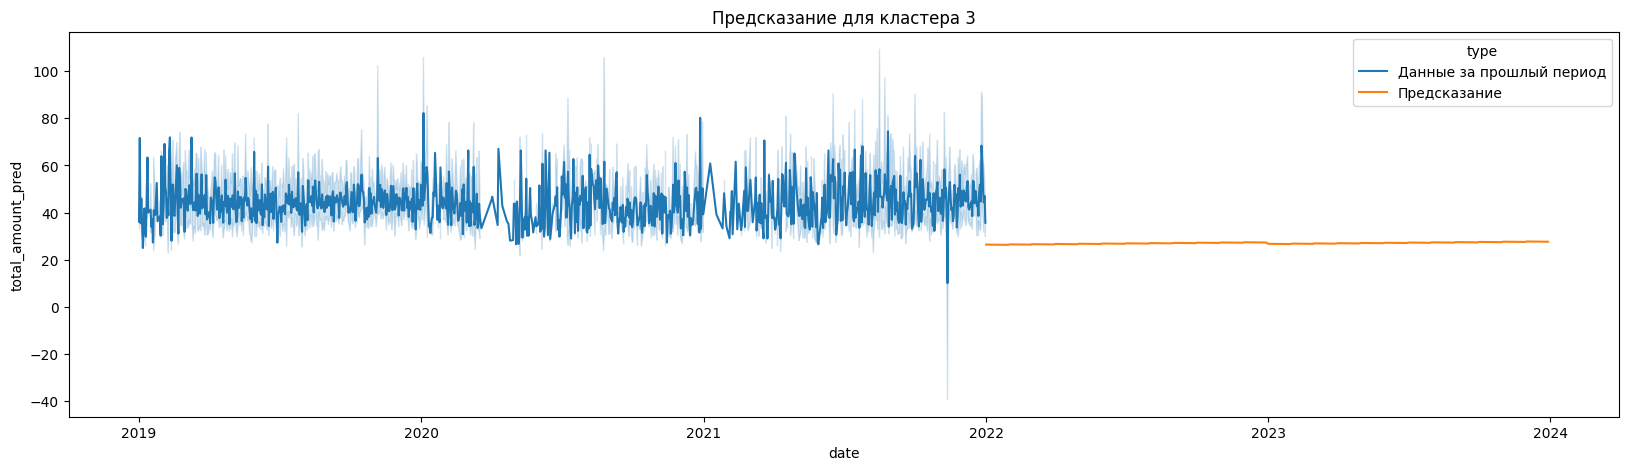

In [139]:
eval_df = X.copy().sample(100_000)
eval_df['total_amount_pred'] = total_amount
eval_df['date'] = eval_df.apply(lambda x: datetime(int(x.year), int(x.month), int(x.day)), axis=1)
eval_df['type'] = 'Данные за прошлый период'

total_amount_preds['type'] = 'Предсказание'
total_amount_preds['date'] = total_amount_preds.apply(lambda x: datetime(int(x.year), int(x.month), int(x.day)), axis=1)

data_for_visualization = pd.concat([eval_df, total_amount_preds])

for cluster in range(3):
    plt.figure(figsize=(20, 5))
    plt.title(f'Предсказание для кластера {cluster+1}')
    sns.lineplot(data=data_for_visualization[data_for_visualization['cluster'] == cluster], x='date', y='total_amount_pred', hue='type')
    plt.show()

####

#### trip_distance

In [141]:
model_trip_distance = LinearRegression()
model_trip_distance.fit(X, trip_distance)

LinearRegression()

#### Делаем прогноз в разрезе каждого кластера

In [145]:
preds = []
for cluster in range(3):
    # Прогнозирование на 2 года вперед
    for year in [2022, 2023]:
      for month in range(1, 13):
            day_range = range(1, 29) if month == 2 else range(1, 30)
            for day in day_range:
                trip_distance_pred = model_trip_distance.predict(pd.DataFrame([[day, month, year, cluster]], columns=X.columns))
                preds.append(np.array([day, month, year, cluster, trip_distance_pred[0]]))

trip_distance_preds = pd.DataFrame(preds, columns=list(X.columns) + ['trip_distance'])
trip_distance_preds.head()

,day,month,year,cluster,trip_distance
0,1.0,1.0,2022.0,0.0,1.909315
1,2.0,1.0,2022.0,0.0,1.909064
2,3.0,1.0,2022.0,0.0,1.908813
3,4.0,1.0,2022.0,0.0,1.908562
4,5.0,1.0,2022.0,0.0,1.908311


#### Визуализация

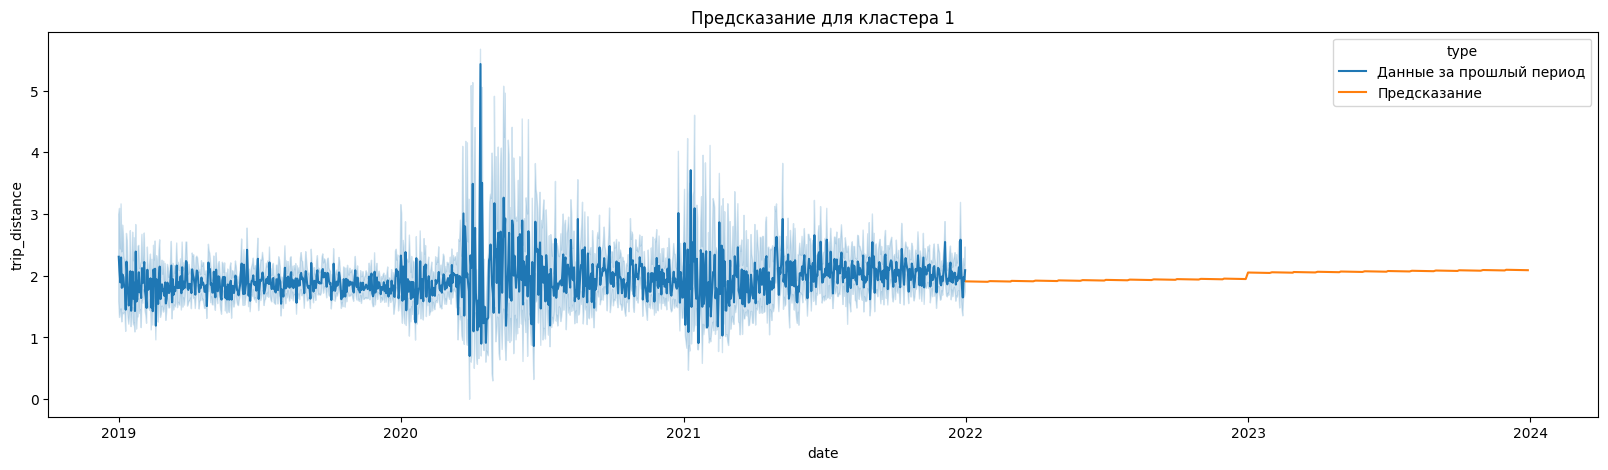

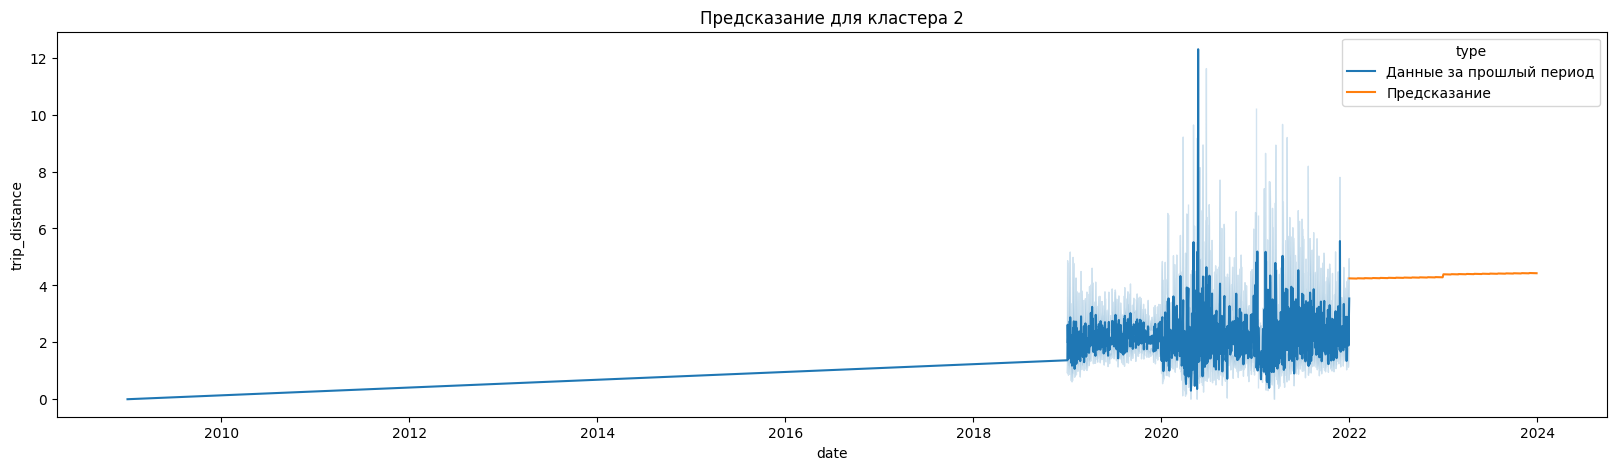

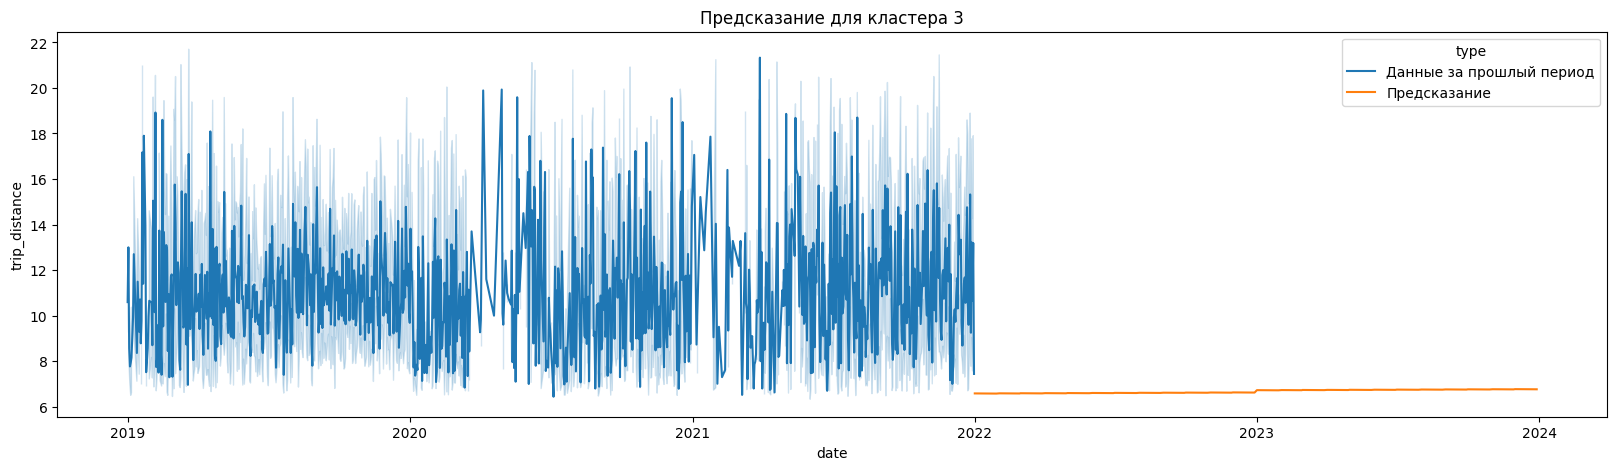

In [149]:
eval_df = X.copy().sample(100_000)
eval_df['trip_distance'] = trip_distance
eval_df['date'] = eval_df.apply(lambda x: datetime(int(x.year), int(x.month), int(x.day)), axis=1)
eval_df['type'] = 'Данные за прошлый период'

trip_distance_preds['type'] = 'Предсказание'
trip_distance_preds['date'] = trip_distance_preds.apply(lambda x: datetime(int(x.year), int(x.month), int(x.day)), axis=1)

data_for_visualization = pd.concat([eval_df, trip_distance_preds])

for cluster in range(3):
    plt.figure(figsize=(20, 5))
    plt.title(f'Предсказание для кластера {cluster+1}')
    sns.lineplot(data=data_for_visualization[data_for_visualization['cluster'] == cluster], x='date', y='trip_distance', hue='type')
    plt.show()

# 3.4 Подготовка отчета

В ходе выполнения модуля C было выполнено следующее:
- Визуализация найденных закономерностей
- Прогнозирование динамики изменения характеристик
- Визуализация прогноза

In [151]:
joblib.dump(model_trip_distance, 'model_trip_distance.pkl')
joblib.dump(model_total_amount, 'model_total_amount.pkl')

['model_total_amount.pkl']

In [8]:
import sqlite3

con = sqlite3.connect('../data/taxi.db')
taxi[['day', 'month', 'year', 'cluster', 'trip_distance', 'total_amount']].sample(1_000_000).to_sql('taxi_for_regression', con=con, if_exists='replace', index=False)

1000000